In [1]:
import os
import time
from collections import defaultdict

import av
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.draw import polygon
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from datasets import EchoNetDataset
from models import EchoNet

In [2]:
model = EchoNet()
model = model.to('cuda')

In [3]:
from torchsummary import summary
summary(model, (1, 112, 112))

RuntimeError: input.size(-1) must be equal to input_size. Expected 256, got 1

In [141]:
root_dir = '/home/tienyu/data/EchoNet-Dynamic/Videos/'

In [142]:
filelist = pd.read_csv('/home/tienyu/data/EchoNet-Dynamic/FileList.csv')
tracing = pd.read_csv('/home/tienyu/data/EchoNet-Dynamic/VolumeTracings.csv')

In [156]:
nof = filelist.NumberOfFrames.iloc[0]

In [157]:
min_num_frames = 64

In [167]:
s = np.random.choice(nof - min_num_frames)
list(range(s, s+ min_num_frames, 4))

In [143]:
valid_clips = tracing.FileName.str.replace('.avi', '').unique()
valid_idx = np.isin(filelist.FileName, valid_clips)

In [144]:
valid_filelist = filelist[valid_idx]

In [149]:
masks = defaultdict(list)
mask_frames = defaultdict(list)
grouped_tracing = tracing.groupby('FileName')

def get_mask(x1, y1, x2, y2):
    x = np.concatenate((x1, x2[::-1]))
    y = np.concatenate((y1, y2[::-1]))
    r, c = polygon(np.rint(y), np.rint(x), (112, 112))
    mask = np.zeros((112, 112))
    mask[r, c] = 1
    
    return mask
    
for k in tracing.FileName.unique():
    g = grouped_tracing.get_group(k).groupby('Frame')
    fs = g.Frame.unique()
    if len(g) == 2:
        for f in fs:
            frame_num = f.item()
            x1, y1, x2, y2 = g.get_group(frame_num)[['X1', 'Y1', 'X2', 'Y2']].values[1:].T
            mask = get_mask(x1, y1, x2, y2)
            masks[k].append(mask)
            mask_frames[k].append(frame_num)
        if masks[k][1].sum() > masks[k][0].sum():
            masks[k][0], masks[k][1] = masks[k][1], masks[k][0]
            mask_frames[k][0], mask_frames[k][1] = mask_frames[k][1], mask_frames[k][0]
        assert masks[k][0].sum() >= masks[k][1].sum(), f'invalid video {k}'

In [150]:
mask_frames[k]

[25, 38]

In [128]:
# filename = valid_filelist[valid_filelist.Split=='TRAIN'].FileName.loc[idx] + '.avi'
filename = '0X124030F8B3C1A5AF.avi'
grouped_df = tracing[tracing.FileName == filename].groupby('Frame')

In [192]:
from torchvision.io import read_video
video = read_video(os.path.join(root_dir, filename), pts_unit='sec')[0]
# video = video.permute(0,3, 1,2)

In [129]:
keys = tracing[tracing.FileName == filename].Frame.unique()

In [131]:
# x1, y1, x2, y2 = grouped_df.get_group(keys[0])[['X1', 'Y1', 'X2', 'Y2']].values[1:].T
# x = np.concatenate((x1, x2[::-1]))
# y = np.concatenate((y1, y2[::-1]))
# r, c = skimage.draw.polygon(np.rint(y), np.rint(x), (112, 112))
# mask = np.zeros((112, 112))
# mask[r, c] = 1
# plt.imshow(mask, cmap='gray')
# pass

22


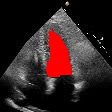

42


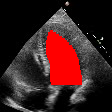

In [132]:
# for key, item in grouped_df:
#     print(grouped_df.get_group(key), "\n\n")
filepath = os.path.join(root_dir, filename)
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
container = av.open(filepath)
k = 0
for j, frame in enumerate(container.decode(video=0)):
    if j in keys:
        print(j)
        coordinates = grouped_df.get_group(j)[['X1', 'Y1', 'X2', 'Y2']].values.tolist()[1:]
        f = frame.to_image()
        draw = ImageDraw.Draw(f)
        for c in coordinates:
            draw.rectangle(c, 'red')
        display(f)

In [14]:
from torchvision.models import resnet18

In [47]:

feature_extractor = feature_extractor.to('cuda')

In [48]:
feature_extractor

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con